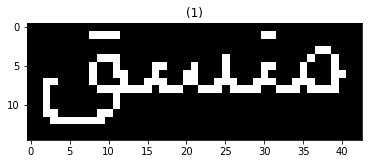

y


In [51]:
import cv2
import numpy as np
from commonfunctions import *
from scipy.stats import iqr
from scipy import stats
# from collections import namedtupl
from dataclasses import dataclass

def SegmentImg2Lines(image):
    roi_list=[]
    gray = rgb2gray(image)
    
    #ret, threshed_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    #show_images([gray])
    kernel = np.ones((8,40), np.uint8)
    img_dilation = cv2.dilate(gray, kernel, iterations=1)
    # find contours
    #show_images([img_dilation])
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort contours
    #sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    for i, ctr in enumerate(ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = image[y:y + h, x:x + w]
        #show_images([roi])
        roi_list.append(roi)
    roi_list.reverse()
    return roi_list

#https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/
def sort_contours(cnts, method="left-to-right"): #from right to left
    # initialize the reverse flag and sort index
    i = 0
 
    # handle if we need to sort in reverse
    #if method == "right-to-left" or method == "bottom-to-top":
    reverse = True
    
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
 
    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes

def Segmentline2word(line):
    roi_list=[]
    locs=[]
    #gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)
    #ret, threshed_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    #show_images([threshed_img])
    gray = rgb2gray(line)
    kernel = np.ones((4,5), np.uint8)
    img_dilation = cv2.dilate(gray, kernel, iterations=1)
    #show_images([img_dilation])
    # find contours
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort contours
    #sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[1])
    sorted_ctrs,_ = sort_contours(ctrs)
    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = line[y:y + h, x:x + w]
        #show_images([roi])
        locs.append((x, y, x + w,y + h))
        roi_list.append(roi)

    return roi_list,locs 


def FindBaselineIndex(line): #Alg. 4
    HP = []
    PV = []
    BaseLineIndex = 0
    thresh,thresh_img = cv2.threshold(line,127,255,cv2.THRESH_BINARY_INV)
    thresh_img = np.asarray(thresh_img)
    thresh_img = line

    HP = np.sum(thresh_img, axis = 1)
    PV_Indices = (HP > np.roll(HP,1)) & (HP > np.roll(HP,-1))
    for i in range(len(PV_Indices)):
        if PV_Indices[i] == True:
            PV.append(HP[i])
    #print(PV)
    MAX = max(PV)
    for i in range(len(HP)):
        if HP[i] == MAX:
            BaseLineIndex = i
    # print(BaseLineIndex)
    # cv2.line(thresh_img, (0, BaseLineIndex), (thresh_img.shape[1], BaseLineIndex), (255,255,255), 1)
    # cv2.imshow('binary',thresh_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return BaseLineIndex
    
    
def FindingMaxTrans(Line, BaseLineIndex): #Alg. 5
    MaxTrans = 0
    MaxTransIndex = BaseLineIndex
    i=BaseLineIndex
    while i > 0:
        CurrTrans = 0
        Flag = 0
        j=0
        while j < Line.shape[1]:
            if Line[i, j] == 1 and Flag == 0:
                CurrTrans += 1
                Flag = 1
            if Line[i, j] != 1 and Flag == 1:
                Flag = 0
            j += 1

        if CurrTrans >= MaxTrans:
            MaxTrans = CurrTrans
            MaxTransIndex = i
        i -= 1
    
    # cv2.line(Line, (0, MaxTransIndex), (Line.shape[1], MaxTransIndex), (50,100,150), 1)
    # cv2.imshow('binary',Line)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return MaxTransIndex

def getVerticalProjectionProfile(image):
    vertical_projection = np.sum(image, axis = 0) 
    return vertical_projection 

def getHorizontalProjectionProfile(image):
    horizontal_projection = np.sum(image, axis = 1) 
    return horizontal_projection 

@dataclass
class SeparationRegions:
    StartIndex: int=0
    EndIndex: int=0
    CutIndex: int=0

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#def CutPointIdentification(Line,Word,MTI): #Alg. 6
def CutPointIdentification(Word,MTI): #Alg. 6 ACCORDING TO THE PSEUDO CODE
    Flag=0
    #LineImage=cv2.imread(Line)
    VP=getVerticalProjectionProfile(Word)
    #MFV = stats.mode(VP)
    VPList = VP.tolist() #to be able to get the MFV
    Beginindex=0#ka2eni bashel el goz2 el black eli 3la el edges fl sora 3ashan ageb mode value mazbota
    EndIndex=len(VPList)
    for i in VPList:
        if i ==0:
            Beginindex+=1
        else:
            break
    for j in range(-1,-30,-1):
        if VPList[j]==0:
            EndIndex-=1
        else:
            break


    i=1
    VPListNew = VPList[Beginindex:EndIndex]
    MFV = max(set(VPListNew), key = VPListNew.count) 
    OutputSeparationRegions= []
    SRAppendFlag=False #initialize but do not append
    while i < Word.shape[1] :
        if SRAppendFlag == False:
            SR = SeparationRegions()
            SRAppendFlag = True
        if Word[MTI,i] == 1 and Word[MTI,i+1] == 0 and Flag == 0 : #CALCULATE END INDEX
            SR.EndIndex = i
            Flag = 1
        if i == (Word.shape[1]-1):
            break
        if Word[MTI,i] == 0 and Word[MTI,i+1] == 1 and Flag == 1 : #CALCULATE START AND CUT INDEX
            SR.StartIndex = i+1
            MidIndex = ( SR.EndIndex + SR.StartIndex )/2
            MidIndex = int(MidIndex)
            IndexesEqualZero = np.where(VP == 0)
            IndexesEqualZero = np.asarray(IndexesEqualZero)
            IndexesEqualZero = IndexesEqualZero.tolist()
            IndexesEqualZero = IndexesEqualZero[0]
            IndexesEqualZero = np.array(IndexesEqualZero)
            #print(IndexesEqualZero)
            IndexesCorrect= IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)] #condition shall be reversed like this
            #IndexesCorrect = IndexesEqualZero[ mask ]
            #print(IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)])

            IndexesLessThanMFVAndEnd = np.where( (VP <= MFV) )
            IndexesLessThanMFVAndEnd = np.asarray(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd=IndexesLessThanMFVAndEnd.tolist()
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd[0]
            IndexesLessThanMFVAndEnd = np.array(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd [ (IndexesLessThanMFVAndEnd > SR.EndIndex) & (IndexesLessThanMFVAndEnd < MidIndex)  ]
            #IndexesLessThanMFVAndEnd.append(2)

            IndexesLessThanMFVAndStartAndEnd = np.where( (VP <= MFV) )
            IndexesLessThanMFVAndStartAndEnd = np.asarray(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd=IndexesLessThanMFVAndStartAndEnd.tolist()
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd[0]
            IndexesLessThanMFVAndStartAndEnd = np.array(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd [ (IndexesLessThanMFVAndStartAndEnd > SR.EndIndex) & (IndexesLessThanMFVAndStartAndEnd < SR.StartIndex) ]
            

            if len(IndexesCorrect) != 0: #neither connected nor overlapped characters
                SR.CutIndex = find_nearest(IndexesCorrect , MidIndex)

            elif VP[MidIndex] == MFV: #connected characters
                SR.CutIndex = MidIndex #line 19 on Alg.
            
            elif len(IndexesLessThanMFVAndEnd) != 0: 
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndEnd , MidIndex)
            
            elif len(IndexesLessThanMFVAndStartAndEnd) != 0: #line 23
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndStartAndEnd , MidIndex)
            else:
                SR.CutIndex = MidIndex
            
            if SRAppendFlag == True:
                OutputSeparationRegions.append(SR)
                SRAppendFlag = False
            Flag = 0
        i+=1
    return OutputSeparationRegions,MFV


def DetectHoles(Word, NextCut, CurrentCut, PreviousCut, MTI):#next is left, previous is right
    LefPixelIndex = 0
    for i in range(NextCut, PreviousCut, 1):
        if Word[MTI, i] == 1:
            LefPixelIndex = i
            break
    
    RightPixelIndex = 0
    for i in range(PreviousCut, NextCut, -1):
        if Word[MTI, i] == 1:
            RightPixelIndex = i
            break
    
    UpPixelIndex = 0
    for i in range(MTI, MTI - 10, -1):
        if Word[i, CurrentCut] == 1:
            UpPixelIndex = i
            break
    
    DownPixelIndex = 0
    for i in range(MTI, MTI + 10, 1):
        if Word[i, CurrentCut+1] == 1: #+1 da psecial case 3ashan law 7arf el heh
            DownPixelIndex = i
            break
    
    if ( np.abs(LefPixelIndex - RightPixelIndex) <=8 ) and ( np.abs(UpPixelIndex - DownPixelIndex ) <=5 ):
        return True
    else:
        return False
    
def DetectBaselineBetweenStartAndEnd(Word, BaseLineIndex, Start, End):#End is left
    if np.sum( Word[BaseLineIndex,End:Start] ) == 0:
        return True #no path found
    return False

def DistanceBetweenTwoPoints(x2,x1):
    dist = np.abs(x2 - x1) 
    return dist

def CheckLine19Alg7(SRL,SR, NextCutIndex, VP, Word,MTI,BaseLineIndex):
    LeftPixelCol = SR.EndIndex
    TopPixelIndex = 0
    for i in range(MTI,MTI-20,-1):
        if Word[i-1,LeftPixelCol] == 0:
            TopPixelIndex = i
            break
    Dist1 = DistanceBetweenTwoPoints( TopPixelIndex,BaseLineIndex )
    Dist2 = DistanceBetweenTwoPoints( MTI,BaseLineIndex )
    if ( SR==SRL[0] and VP[NextCutIndex] == 0) or ( Dist1 < (0.5*Dist2) ) :
        return True
    return False
        
def CheckStroke(Word, NextCut, CurrentCut, PreviousCut, MTI,BaseLineIndex,SR):
    HPAbove = getHorizontalProjectionProfile( Word[0:BaseLineIndex,SR.EndIndex:SR.StartIndex] )
    HPBelow = getHorizontalProjectionProfile( Word[BaseLineIndex: ,SR.EndIndex:SR.StartIndex] )
            
    SHPB = np.sum(HPBelow)
    SHPA = np.sum(HPAbove)
    
    TopPixelIndex = 0
    LeftPixelCol = SR.EndIndex
    for i in range(MTI,MTI-20,-1):
        if Word[i-1,LeftPixelCol] == 0:
            TopPixelIndex = i
            break
            
    Dist1 = DistanceBetweenTwoPoints( TopPixelIndex,BaseLineIndex )
    Dist1 = int(Dist1)
    print(Dist1)
    #HP = getHorizontalProjectionProfile(Word)
    HP = getHorizontalProjectionProfile(Word[:,SR.EndIndex:SR.StartIndex])
    HPList = HP.tolist()
    HPMode = max(set(HPList), key = HPList.count) 
    HPList.sort()
    SecondPeakValue = HPList[-2]
    
    VP=getVerticalProjectionProfile(Word)
    VPList = VP.tolist()
    MFV = max(set(VPList), key = VPList.count) 
    
    Holes = DetectHoles(Word, NextCut, CurrentCut, PreviousCut, MTI)
    if SHPA > SHPB and not Holes:#and (HPMode == MFV) and Dist1 <= (2*SecondPeakValue):
        return True
    return False

def CheckDotsAboveOrBelow(Word, SR, MTI,BaseLineIndex):
    Dots = False
    for i in range(MTI-2, MTI-6, -1):
        for j in range(SR.EndIndex+2, SR.StartIndex):
            if Word[i, j] == 1:
                Dots = True
                return Dots
    for i in range(BaseLineIndex+2, BaseLineIndex+6, 1):
        for j in range(SR.EndIndex+1, SR.StartIndex):
            if Word[i, j] == 1:
                Dots = True
                return Dots
    return Dots
    

def SeparationRegionFilteration(Word, SRL, BaseLineIndex, MTI, MFV): #Alg. 7
    i=0
    VP=getVerticalProjectionProfile(Word)
    ValidSeparationRegions = []
    while i < len(SRL):
        SR = SRL[i]
        StartEndPath = Word[BaseLineIndex, SR.EndIndex+1 :SR.StartIndex]
        #print(not(1 in StartEndPath))
        PrevIndex = i-1
        NextIndex = i+1
        
        if VP[SR.CutIndex]==0:
            ValidSeparationRegions.append(SR)
            i+=1
        #elif DetectHoles(Word, SRL[PrevIndex].CutIndex, SR.CutIndex, SRL[NextIndex].CutIndex, MTI):
        elif DetectHoles(Word, SR.EndIndex, SR.CutIndex, SR.StartIndex, MTI):
                i+=1
        elif not(1 in StartEndPath):
            ValidSeparationRegions.append(SR)
            i+=1
        elif DetectBaselineBetweenStartAndEnd(Word, BaseLineIndex, SR.StartIndex, SR.EndIndex):
            HPAbove = getHorizontalProjectionProfile( Word[0:BaseLineIndex,SR.EndIndex:SR.StartIndex] )
            HPBelow = getHorizontalProjectionProfile( Word[BaseLineIndex: ,SR.EndIndex:SR.StartIndex] )
            
            SHPB = np.sum(HPBelow)
            SHPA = np.sum(HPAbove)
            
            if SHPB > SHPA :
                i+=1
            elif VP[ SR.CutIndex ] < MFV : #check sign later
                ValidSeparationRegions.append(SR)
                i+=1
            else:
                i+=1
        elif NextIndex >= len(SRL):
            if not DetectHoles(Word, SR.EndIndex, SR.CutIndex, SR.StartIndex, MTI):
                ValidSeparationRegions.append(SR)
            break
        #next is line 19 in Alg.
        elif CheckLine19Alg7(SRL,SR, SRL[i+1].CutIndex, VP, Word,MTI,BaseLineIndex):
            i+=1
        #line 22
        elif not CheckStroke(Word, SRL[i+1].CutIndex, SR.CutIndex, SRL[i-1].CutIndex, MTI,BaseLineIndex,SR) :
            DetectLine = DetectBaselineBetweenStartAndEnd(Word, BaseLineIndex, SRL[i+1].StartIndex, SRL[i+1].EndIndex)
            if ~DetectLine and SRL[i+1].CutIndex <= MFV:
                i+=1
            else:
                ValidSeparationRegions.append(SR)
                i+=1 #line 27
        elif CheckStroke(Word, SRL[i+1].CutIndex, SR.CutIndex, SRL[i-1].CutIndex, MTI,BaseLineIndex,SR) and CheckDotsAboveOrBelow(Word, SR, MTI,BaseLineIndex):#line 29
            ValidSeparationRegions.append(SR)
            i+=1 
            i+=2#law kan 7arf seen fl nos masln
        elif CheckStroke(Word, SRL[i+1].CutIndex, SR.CutIndex, SRL[i-1].CutIndex, MTI,BaseLineIndex,SR) and not  CheckDotsAboveOrBelow(Word, SR, MTI,BaseLineIndex) :#line 31
            next1 = i+1
            next2 = i+2
            next3 = i+3
            if next1 >= len(SRL) or next2 >= len(SRL) or next3 >= len(SRL):
                ValidSeparationRegions.append(SR)
                i+=1
                continue
            if CheckStroke(Word, SRL[i+2].CutIndex, SRL[i+1].CutIndex, SRL[i].CutIndex, MTI,BaseLineIndex,SRL[i+1]) and CheckDotsAboveOrBelow(Word, SRL[i+1], MTI,BaseLineIndex) :
                ValidSeparationRegions.append(SR)
                i+=3
            else:
                SEGNStroke    = CheckStroke(Word, SRL[i+2].CutIndex, SRL[i+1].CutIndex, SRL[i].CutIndex, MTI,BaseLineIndex,SRL[i+1]) 
                SEGNDots      = CheckDotsAboveOrBelow(Word, SRL[i+1], MTI,BaseLineIndex)
                SEGNNStroke   =  CheckStroke(Word, SRL[i+3].CutIndex, SRL[i+2].CutIndex, SRL[i+1].CutIndex, MTI,BaseLineIndex,SRL[i+2])
                SEGNNDOTSDots = CheckDotsAboveOrBelow(Word, SRL[i+2], MTI,BaseLineIndex)
                if SEGNStroke and SEGNNStroke and (SEGNNDOTSDots or SEGNDots): #di law true yeb2a seen aw sheen masln
                    ValidSeparationRegions.append(SR)
                    i+=3
                else: #7arf noon masln
                    ValidSeparationRegions.append(SR)
                    i+=1
    return ValidSeparationRegions 


def main(thresh):
    
    #cv2.imshow('str',thresh/255)   

    lines=SegmentImg2Lines(thresh)
    
    words,_ = Segmentline2word(lines[0])
    
    word=words[1]
    BaselineIndex = FindBaselineIndex(words[4])
    show_images([words[3]])
    #print(BaselineIndex)
    MaxTransitionIndex = FindingMaxTrans(word/255, BaselineIndex)
            # print(MaxTransitionIndex)

    SeparationRegions,MFV = CutPointIdentification(word/255, MaxTransitionIndex)
            #print("Seeing Cut Point Identification")
            # for SR in SeparationRegions:
            #     cv2.line(thresh, (BaselineIndex, SR.StartIndex), (BaselineIndex, SR.StartIndex+1), (0, 20, 200), 10)
            #     print(SR.StartIndex)
            #     print(SR.EndIndex)
            #     print(SR.CutIndex)
            #     print("*********")

    ValidSeparationRegions = SeparationRegionFilteration(word/255, SeparationRegions, BaselineIndex, 
                                                                MaxTransitionIndex, MFV)
            #print(ValidSeparationRegions)

#     for i in range (len(ValidSeparationRegions)):
#         word[MaxTransitionIndex,int(ValidSeparationRegions[i].CutIndex)] = 150

#     show_images([word])


im = cv2.imread('capr1.png', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY_INV)
#show_images([thresh])
#main(thresh)
lines=SegmentImg2Lines(thresh)
    
words,_ = Segmentline2word(lines[8])
    
#word=words[1]
#BaselineIndex = FindBaselineIndex(words[4])
show_images([words[0]])
print("y")




#2, 7, 10,11,12,13, 15, 17, 19,  21, 22, 23, 26, 28, 29, 30, 31 ok
#14(one extra region fl ظ i ), 16(one error in لا i), 18(one extra region in ذ i)
#24(one missing region between م and ف i), 25(one error in teh marbota)

In [53]:
def try_to_change_list_contents(the_list):
    print('got', the_list)
    the_list[2]='two'
    print('changed to', the_list)

outer_list = {1:'one'}

print('before, outer_list =', outer_list)
try_to_change_list_contents(outer_list)
print('after, outer_list =', outer_list)

before, outer_list = {1: 'one'}
got {1: 'one'}
changed to {1: 'one', 2: 'two'}
after, outer_list = {1: 'one', 2: 'two'}
